In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [2]:
dir_covid_data = '../../datalake/silver/covid_data/'
covid_file = f'{dir_covid_data}/full_grouped_filtro_1.csv'
covid_data = pd.read_csv(covid_file)
covid_data.drop('Unnamed: 0', axis=1, inplace=True)
covid_data['Date'] = pd.to_datetime(covid_data['Date'])
covid_data.set_index('Date', inplace=True)

# Dados necessários para o ARIMA
reg_data = covid_data[['Country/Region', 'New cases']].dropna() # Remoção de valores NaN

In [3]:
reg_data_ar = reg_data[reg_data['Country/Region'] == 'Argentina']
reg_data_ar = reg_data_ar[['New cases']]
reg_data_ar = reg_data_ar.loc[reg_data_ar.ne(0).idxmax()[0]:]
train_data = reg_data_ar.iloc[:103]
test_data = reg_data_ar.iloc[103:]

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [12]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
# Sequence size has a impact on prediction, expecialy since COVID is npredictable
seq_size = 7 # number os steps (lookback)
n_features = 1 # number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled,
                                      train_scaled,
                                      length = seq_size,
                                      batch_size = 1
                                      )
print('Total number of samples in the original training data = ', len(train_data))
print('Total number of samples in the generated data = ', len(train_generator))


Total number of samples in the original training data =  103
Total number of samples in the generated data =  96


In [17]:
# check data shape from generator
x, y = train_generator[10] # check train generator
# takes 7 days as x and 8th day as y (for seq_size=7)

In [19]:
y

array([[0.0202482]])

In [20]:
# also generate test data
test_generator = TimeseriesGenerator(test_scaled,
                                     test_scaled,
                                     length = seq_size,
                                     batch_size = 1
                                     )


In [21]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

In [22]:
# define model
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, 
               input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 128)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118,081
Trainable params: 118,081
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=50, steps_per_epoch=10)


Epoch 1/50
10/10 [==============================] - 1s 60ms/step - loss: 0.0117 - val_loss: 1.1076
Epoch 2/50
10/10 [==============================] - 1s 50ms/step - loss: 0.0151 - val_loss: 1.4673
Epoch 3/50
10/10 [==============================] - 0s 44ms/step - loss: 0.0013 - val_loss: 2.8383
Epoch 4/50
10/10 [==============================] - 0s 48ms/step - loss: 0.0024 - val_loss: 4.8032
Epoch 5/50
10/10 [==============================] - 0s 34ms/step - loss: 0.0067 - val_loss: 4.0643
Epoch 6/50
10/10 [==============================] - 0s 24ms/step - loss: 3.9463e-04 - val_loss: 3.0090
Epoch 7/50
10/10 [==============================] - 0s 24ms/step - loss: 0.0045 - val_loss: 2.5913
Epoch 8/50
10/10 [==============================] - 0s 25ms/step - loss: 0.0023 - val_loss: 2.5385
Epoch 9/50
10/10 [==============================] - 0s 25ms/step - loss: 0.0059 - val_loss: 2.0867
Epoch 10/50
10/10 [==============================] - 0s 29ms/step - loss: 0.0038 - val_loss: 1.0492
Epoch

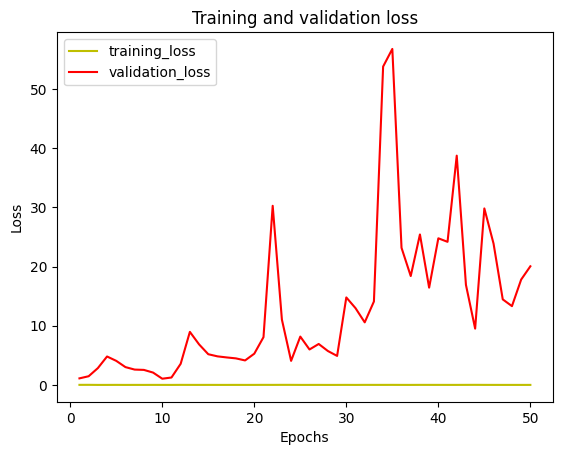

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='training_loss')
plt.plot(epochs, val_loss, 'r', label='validation_loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
prediction = []
current_batch = train_scaled[-seq_size:]
current_batch = current_batch.reshape(1, seq_size, n_features)

In [ ]:
import numpy as np

def predict(model, current_batch):
    return model.predict(current_batch)[0]

# Vectorize the prediction function using NumPy's "vectorize" function
vectorized_predict = np.vectorize(predict)

future = 7

# Use NumPy's "arange" function to create an array of indices
indices = np.arange(len(test_data) + future)

# Use NumPy's "apply_along_axis" function to apply the prediction function to each index in the array
prediction = np.apply_along_axis(vectorized_predict, 0, model, current_batch)

# Use NumPy's "roll" function to shift the elements of the current batch array
current_batch = np.roll(current_batch, shift=-1, axis=1)
current_batch[:, -1, :] = prediction


In [51]:
import numpy as np
future = 7
for i in range(len(test_data) + future):
    current_pred = model.predict(current_batch)[0]
    prediction.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :],
                              [[current_pred]],
                              axis=1)


1/1 [==============================] - 0s 42ms/step


In [54]:
rescaled_prediction = scaler.inverse_transform(prediction)


In [55]:
time_series_array = test_data.index

In [56]:
for k in range(0, future):
    time_series_array = time_series_array.append(time_series_array[-1:]) + pd.DateOffset(1)

In [57]:
df_forecast = pd.DataFrame(columns=['actual_confirmed', 'predicted'],
                           index=time_series_array)

In [59]:
test_data.head()

,New cases
Date,
2020-06-14,1282
2020-06-15,1208
2020-06-16,1374
2020-06-17,1393
2020-06-18,1958


In [60]:
df_forecast.loc[:, 'predicted'] = rescaled_prediction[:, 0]
df_forecast.loc[:, 'actual_confirmed'] = test_data['New cases']


<AxesSubplot:title={'center':'prediction for next 7 days'}, xlabel='Date'>

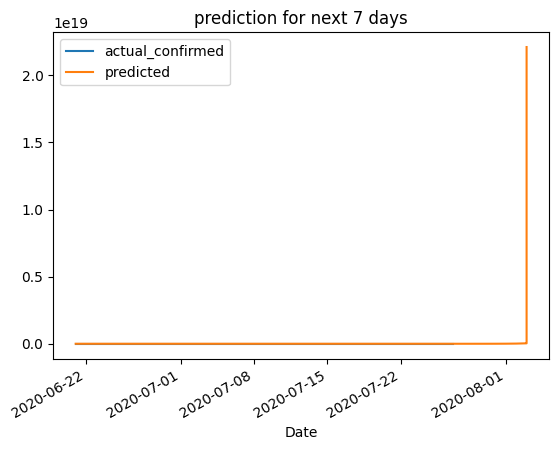

In [61]:
df_forecast.plot(title='prediction for next 7 days')